In [20]:
import os
import pandas as pd, numpy as np
import boto3

In [21]:
# check that we're getting the environment variable = senateScraper
print(os.getenv('DYNAMO_TABLE_NAME'))

senateScraper


In [22]:
dynamodb = boto3.resource(
            'dynamodb',
            region_name='eu-north-1',
            aws_access_key_id=os.getenv('AWS_ACCESS_KEY'),
            aws_secret_access_key=os.getenv('AWS_SECRET_KEY')
)

Let's have a look at our data

In [23]:
response = dynamodb.Table(os.getenv('DYNAMO_TABLE_NAME')).scan()
data = response['Items']
df = pd.DataFrame(data)
df.head()

,Tx_Type,Comment,Date,Asset_Type,Filer,Owner,Ticker,Amount,id,Asset_Name
0,Sale (Partial),None,2025-09-04,Stock,"Whitehouse, Sheldon",Self,AAPL,"$15,001 - $50,000",3a7413ed5ad650c3e08beedc139b362c,Apple Inc
1,Sale (Full),None,2023-09-20,Stock,"Whitehouse, Sheldon",Spouse,WBD,"$1,001 - $15,000",f32d3026cd93624cf66552159148bd02,"Warner Bros. Discovery, Inc. - Series A Common..."
2,Sale (Full),None,2014-06-19,,"Collins, Susan M.",Spouse,PG,"$1,001 - $15,000",0ba73920a5ed82d8e83d9f1230fb6668,The Procter & Gamble Company (NYSE)
3,Purchase,None,2016-03-31,Stock,"Cassidy, Bill",Spouse,PG,"$1,001 - $15,000",ebc244ac5e18600af7b7517299893b8d,The Procter & Gamble Company
4,Sale (Partial),None,2019-09-25,Stock,"Moran, Jerry",Spouse,XOM,"$1,001 - $15,000",609a7b92833dc517cfd19953347d4a9f,Exxon Mobil Corporation


In [24]:
df.describe()

,Tx_Type,Comment,Date,Asset_Type,Filer,Owner,Ticker,Amount,id,Asset_Name
count,5084,456,5084,5084,5084,5084,3936,5084,5084,5084
unique,4,206,1380,9,54,4,932,8,5084,2491
top,Purchase,MFI67,2015-02-13,Stock,"Tuberville, Tommy",Joint,AAPL,"$1,001 - $15,000",3a7413ed5ad650c3e08beedc139b362c,Apple Inc.
freq,2606,40,83,3661,1056,1827,74,3176,1,43


In [25]:
df['Amount'].unique()

array(['$15,001 - $50,000', '$1,001 - $15,000', '$50,001 - $100,000',
       '$500,001 - $1,000,000', '$100,001 - $250,000',
       '$250,001 - $500,000', '$1,000,001 - $5,000,000',
       '$5,000,001 - $25,000,000'], dtype=object)

I'll create a new column med_amt to analyse the amounts as a numeric median of the range

In [26]:
df['med_amt'] = df['Amount'].apply(lambda x: np.mean([int(i) for i in x.replace('$','').replace(',','').split('-')]) if '-' in x else int(x.replace('$','').replace(',','')) )
df[['Amount','med_amt']].head()

,Amount,med_amt
0,"$15,001 - $50,000",32500.5
1,"$1,001 - $15,000",8000.5
2,"$1,001 - $15,000",8000.5
3,"$1,001 - $15,000",8000.5
4,"$1,001 - $15,000",8000.5


In [27]:
df['Date'] = pd.to_datetime(df['Date'])
df.loc[:, 'year'] = df['Date'].dt.year
df.loc[:, 'month'] = df['Date'].dt.month
df.loc[:, 'day'] = df['Date'].dt.day
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5084 entries, 0 to 5083
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tx_Type     5084 non-null   object        
 1   Comment     456 non-null    object        
 2   Date        5084 non-null   datetime64[ns]
 3   Asset_Type  5084 non-null   object        
 4   Filer       5084 non-null   object        
 5   Owner       5084 non-null   object        
 6   Ticker      3936 non-null   object        
 7   Amount      5084 non-null   object        
 8   id          5084 non-null   object        
 9   Asset_Name  5084 non-null   object        
 10  med_amt     5084 non-null   float64       
 11  year        5084 non-null   int32         
 12  month       5084 non-null   int32         
 13  day         5084 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3), object(9)
memory usage: 496.6+ KB


Let's have a look at stock purchases

In [28]:
buys = df[(df['Tx_Type']=='Purchase') & (df['Ticker'])]
buys.head()

,Tx_Type,Comment,Date,Asset_Type,Filer,Owner,Ticker,Amount,id,Asset_Name,med_amt,year,month,day
3,Purchase,None,2016-03-31,Stock,"Cassidy, Bill",Spouse,PG,"$1,001 - $15,000",ebc244ac5e18600af7b7517299893b8d,The Procter & Gamble Company,8000.5,2016,3,31
5,Purchase,None,2016-09-12,Stock,"Reed, John F.",Self,TMO,"$1,001 - $15,000",274e5cd9f3108b6f9b37f15f6c719b58,"Thermo Fisher Scientific, Inc.",8000.5,2016,9,12
9,Purchase,None,2019-04-18,Stock,"Whitehouse, Sheldon",Joint,MCD,"$1,001 - $15,000",e20de8feaa3a360c75f9e2d516dc8e91,McDonald's Corporation,8000.5,2019,4,18
14,Purchase,None,2018-05-24,Stock,"Whitehouse, Sheldon",Joint,BUD,"$1,001 - $15,000",3a61b528418743b7046acc842fcac619,Anheuser-Busch InBev SA/NV,8000.5,2018,5,24
17,Purchase,None,2018-10-30,Stock,"Peters, Gary",Self,T,"$1,001 - $15,000",83c4bdf5092eea2b7b2cc55348ceb8d7,AT&T Inc.,8000.5,2018,10,30


In [29]:
buys.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1862 entries, 3 to 5077
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tx_Type     1862 non-null   object        
 1   Comment     127 non-null    object        
 2   Date        1862 non-null   datetime64[ns]
 3   Asset_Type  1862 non-null   object        
 4   Filer       1862 non-null   object        
 5   Owner       1862 non-null   object        
 6   Ticker      1862 non-null   object        
 7   Amount      1862 non-null   object        
 8   id          1862 non-null   object        
 9   Asset_Name  1862 non-null   object        
 10  med_amt     1862 non-null   float64       
 11  year        1862 non-null   int32         
 12  month       1862 non-null   int32         
 13  day         1862 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3), object(9)
memory usage: 196.4+ KB


In [30]:
import seaborn as sns


Text(0.5, 1.0, 'Total Amount Invested by US Senators per Year')

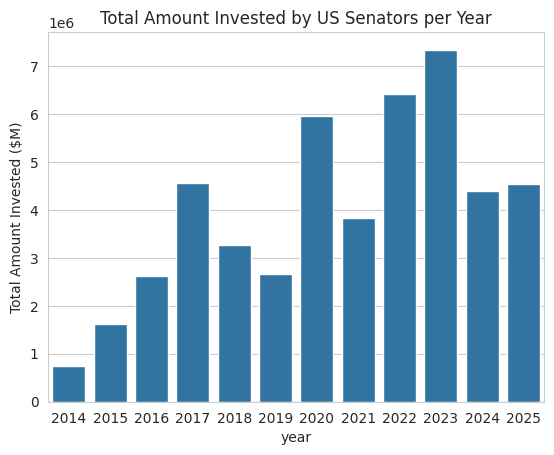

In [31]:
sns.set_style('whitegrid')
agg = buys.groupby('year', as_index=False)['med_amt'].sum()
g = sns.barplot(data=agg, x='year', y='med_amt', errorbar=None)
g.set_ylabel('Total Amount Invested ($M)')
g.set_title('Total Amount Invested by US Senators per Year')


In [32]:
# Which senators do we have?
df['Filer'].unique()

array(['Whitehouse, Sheldon', 'Collins, Susan M.', 'Cassidy, Bill',
       'Moran, Jerry', 'Reed, John F.', 'Boozman, John', 'Peters, Gary',
       'Capito, Shelley Moore', 'Wyden, Ron', 'Murray, Patty',
       'Scott, Rick', 'Mullin, Markwayne', 'Tuberville, Tommy',
       'Sullivan, Dan', 'Fetterman, John', 'Tillis, Thom', 'Hoeven, John',
       'Coons, Chris', 'McConnell, A. Mitchell Jr.', 'Ricketts, Pete',
       'Cornyn, John', 'McCormick, David H.', 'King, Angus',
       'Warner, Mark', 'Van Hollen, Chris', 'Hickenlooper, John',
       'Graham, Lindsey', 'Smith, Tina', 'Moody, Ashley B.',
       'Banks, James E.', 'Hagerty, Bill', 'Duckworth, Tammy',
       'Kaine, Tim', 'Fischer, Deb', 'Bennet, Michael', 'Rounds, Mike',
       'Britt, Katie', 'Kennedy, John', 'Cruz, Ted', 'Rosen, Jacky',
       'Cantwell, Maria', 'Curtis, John R.', 'Wicker, Roger',
       'Moreno, Bernardo', 'Thune, John', 'Lummis, Cynthia',
       'Shaheen, Jeanne', 'Barrasso, John', 'Crapo, Michael D.',
      

/tmp/ipykernel_5039/2402594497.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


Text(0, 0.5, 'Total investment (M $)')

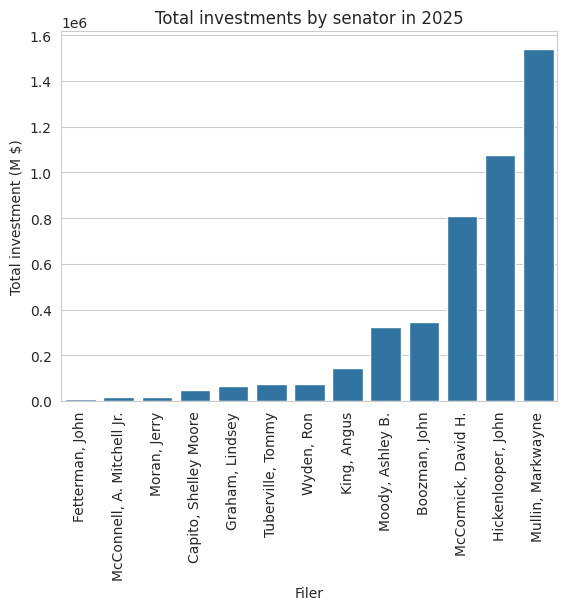

In [33]:
# Who has invested the most in 2025?
sorted_2025 = buys[buys['year']==2025].groupby('Filer')['med_amt'].sum().sort_values(ascending=True)

g = sns.barplot(x=sorted_2025.index, y=sorted_2025.values)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Total investments by senator in 2025')
g.set_ylabel('Total investment (M $)')

I'll save the rest of the analysis for the later steps where I develop a trading strategy